## Correct Attempt

### Initialisation + helper functions. 
Volatility is classified into different regimes for different strategies

In [71]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm

# Helper: Black-Scholes formula
def bs_price(S, K, T, r, sigma, option_type='call'):
    if T <= 0:
        return max(S - K, 0) if option_type == 'call' else max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
# Classify volatility regimes
def classify_regime(vxn_value):
    if vxn_value < 20:
        return 'Low'
    elif 20 <= vxn_value <= 35:
        return 'Moderate'
    else:
        return 'High'

### Load Data
Loaded options data, qqq daily and vxn which measures implied volatility of qqq

In [72]:
# Load your data
options_data = pd.read_csv('Data/qqq_option_data_2018_2023.csv')  # Replace path if needed
options_data['date'] = pd.to_datetime(options_data['date'])
options_data['strike_price'] = options_data['strike_price']/1000
qqq_daily = yf.download('QQQ', start='2018-01-01', end='2023-5-3', interval='1d').reset_index()
vxn_daily = yf.download('^VXN', start='2018-01-01', end='2023-5-3', interval='1d').reset_index()
riskfreerate = pd.read_csv('Data/zero_coupon_rates_2018_2023.csv')
riskfreerate_short = riskfreerate[riskfreerate['days'] == 7].copy()
riskfreerate_short['risk_free_daily'] = riskfreerate_short['rate'] / 100
riskfreerate_short['date'] = pd.to_datetime(riskfreerate_short['date'])


#preprocess
if isinstance(vxn_daily.columns, pd.MultiIndex):
    vxn_daily.columns = vxn_daily.columns.get_level_values(0)  # Drop the 'Ticker' second level
vxn_daily = vxn_daily.reset_index()
if isinstance(qqq_daily.columns, pd.MultiIndex):
    qqq_daily.columns = qqq_daily.columns.get_level_values(0)  # Drop the 'Ticker' second level
qqq_daily = qqq_daily.reset_index()
qqq_daily = qqq_daily.rename(columns={'Close': 'QQQ_Close'})
vxn_daily['Regime'] = vxn_daily['Close'].apply(classify_regime)
qqq_daily = qqq_daily.merge(vxn_daily[['Date', 'Regime']], on='Date', how='left')
qqq_daily = qqq_daily.merge(riskfreerate_short[['date', 'risk_free_daily']], 
                            left_on='Date', 
                            right_on='date', 
                            how='left')

options_data = options_data.merge(qqq_daily[['Date', 'QQQ_Close']], left_on='date', right_on='Date', how='left')
options_data['moneyness'] = abs(options_data['strike_price'] - options_data['QQQ_Close'])
options_data.rename(columns={
    'strike_price': 'strike',
    'cp_flag': 'type',
    'exdate': 'expiration_date_option',
}, inplace=True)

print(options_data.columns)
print(qqq_daily.columns)
options_data.head(5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Index(['date', 'expiration_date_option', 'type', 'strike', 'delta', 'gamma',
       'impl_volatility', 'best_bid', 'best_offer', 'volume', 'open_interest',
       'optionid', 'secid', 'Date', 'QQQ_Close', 'moneyness'],
      dtype='object')
Index(['index', 'Date', 'QQQ_Close', 'High', 'Low', 'Open', 'Volume', 'Regime',
       'date', 'risk_free_daily'],
      dtype='object')


,date,expiration_date_option,type,strike,delta,gamma,impl_volatility,best_bid,best_offer,volume,open_interest,optionid,secid,Date,QQQ_Close,moneyness
0,2018-01-02,2018-02-02,C,148.5,0.892498,0.021384,0.186879,10.49,10.70,4.0,40.0,118524041.0,107899.0,2018-01-02,150.949295,2.449295
1,2018-01-02,2018-02-02,C,149.5,0.875178,0.024551,0.181047,9.61,9.73,2.0,12.0,118524043.0,107899.0,2018-01-02,150.949295,1.449295
2,2018-01-02,2018-02-02,C,153.0,0.791621,0.039376,0.157560,6.48,6.56,3.0,42.0,118524049.0,107899.0,2018-01-02,150.949295,2.050705
3,2018-01-02,2018-02-02,C,153.5,0.776244,0.042127,0.153491,6.05,6.11,11.0,98.0,118524050.0,107899.0,2018-01-02,150.949295,2.550705
4,2018-01-02,2018-02-02,C,154.0,0.758090,0.044900,0.150400,5.63,5.69,20.0,91.0,118524051.0,107899.0,2018-01-02,150.949295,3.050705


### Parameters
option strategy parameters, initial cash, helper function

In [73]:
# === Setup ===
rebalance_frequency = 14  # biweekly
strike_offset_call_light_collar = 1.05  # 5% OTM
strike_offset_put_light_collar = 0.95   # 5% OTM
strike_offset_put_spread_buy = 0.95  # Buy put 5% OTM
strike_offset_put_spread_sell = 0.85 # Sell put 15% OTM
strike_offset_put_protective = 0.97  # Buy slightly OTM (3%)

initial_investment = 10_000_000
stock_quantity = initial_investment / qqq_daily['QQQ_Close'].iloc[0]
cash = 0
portfolio_value = []
active_options = []

# === Helper function to select closest strike ===
def find_closest_option(row, options_df, option_type, strike_target):
    candidates = options_df[
        (options_df['date'] == row['Date']) &
        (options_df['type'] == option_type)
    ].copy()
    if candidates.empty:
        return None
    candidates['strike_diff'] = abs(candidates['strike'] - strike_target)
    return candidates.sort_values('strike_diff').iloc[0]

### Simulation / backtest

In [74]:
# === Run the Simulation ===
for i, row in qqq_daily.iterrows():
    S = row['QQQ_Close']
    r = row["risk_free_daily"]

    if i % rebalance_frequency == 0:
        # Close old options
        active_options = []
        regime = row['Regime'] # <------------ REPLACE WITH RAMIL / CYNTHIA'S CODE !!!!!!!

        if regime == 'Low':  # Light Collar Strategy
            put_strike = S * strike_offset_put_light_collar
            call_strike = S * strike_offset_call_light_collar

            put_option = find_closest_option(row, options_data, 'P', put_strike)
            call_option = find_closest_option(row, options_data, 'C', call_strike)

            if put_option is not None:
                premium = put_option['best_offer'] * 100
                cash -= premium
                active_options.append({
                    'type': 'put',
                    'strike': put_option['strike'],
                    'expiration': put_option['expiration_date_option'],
                    'entry_price': put_option['best_offer'],
                    'contracts': stock_quantity / 100,
                    'direction': 1,
                    'implied_vol': put_option['impl_volatility']
                })

            if call_option is not None:
                premium = call_option['best_bid'] * 100
                cash += premium
                active_options.append({
                    'type': 'call',
                    'strike': call_option['strike'],
                    'expiration': call_option['expiration_date_option'],
                    'entry_price': call_option['best_bid'],
                    'contracts': stock_quantity / 100,
                    'direction': -1,
                    'implied_vol': call_option['impl_volatility']
                })

        elif regime == 'Moderate': # Protective Put Spread Strategy
            put_buy_strike = S * strike_offset_put_spread_buy
            put_sell_strike = S * strike_offset_put_spread_sell

            put_buy_option = find_closest_option(row, options_data, 'P', put_buy_strike)
            put_sell_option = find_closest_option(row, options_data, 'P', put_sell_strike)

            if put_buy_option is not None:
                premium = put_buy_option['best_offer'] * 100
                cash -= premium
                active_options.append({
                    'type': 'put',
                    'strike': put_buy_option['strike'],
                    'expiration': put_buy_option['expiration_date_option'],
                    'entry_price': put_buy_option['best_offer'],
                    'contracts': stock_quantity / 100,
                    'direction': 1,
                    'implied_vol': put_buy_option['impl_volatility']
                })

            if put_sell_option is not None:
                premium = put_sell_option['best_bid'] * 100
                cash += premium
                active_options.append({
                    'type': 'put',
                    'strike': put_sell_option['strike'],
                    'expiration': put_sell_option['expiration_date_option'],
                    'entry_price': put_sell_option['best_bid'],
                    'contracts': stock_quantity / 100,
                    'direction': -1,
                    'implied_vol': put_sell_option['impl_volatility']
                })

        elif regime == 'High': # Protective Put Only Strategy
            put_strike = S * strike_offset_put_protective

            put_option = find_closest_option(row, options_data, 'P', put_strike)

            if put_option is not None:
                premium = put_option['best_offer'] * 100
                cash -= premium
                active_options.append({
                    'type': 'put',
                    'strike': put_option['strike'],
                    'expiration': put_option['expiration_date_option'],
                    'entry_price': put_option['best_offer'],
                    'contracts': stock_quantity / 100,
                    'direction': 1,
                    'implied_vol': put_option['impl_volatility']
                })

    # === Daily MTM of Active Options === (pricing)
    option_value = 0
    for hedge in active_options:
        expiration_date = pd.to_datetime(hedge['expiration'])
        T = (expiration_date - row['Date']).days / 365
        if T > 0:
            price = bs_price(S, hedge['strike'], T, risk_free_rate, hedge['implied_vol'], hedge['type'])
        else:
            price = 0
        option_value += hedge['contracts'] * hedge['direction'] * price * 100

    total_value = stock_quantity * S + cash + option_value
    portfolio_value.append(total_value)

# Save
qqq_daily['Portfolio_Value'] = portfolio_value

### Results


=== Hedged Portfolio Metrics ===
Cumulative Return: 108.25%
Annualized Return: 14.77%
Annualized Volatility: 18.99%
Sharpe Ratio: 0.78
Max Drawdown: -34.12%

=== Unhedged QQQ Metrics ===
Cumulative Return: 108.90%
Annualized Return: 14.84%
Annualized Volatility: 25.90%
Sharpe Ratio: 0.57
Max Drawdown: -35.12%


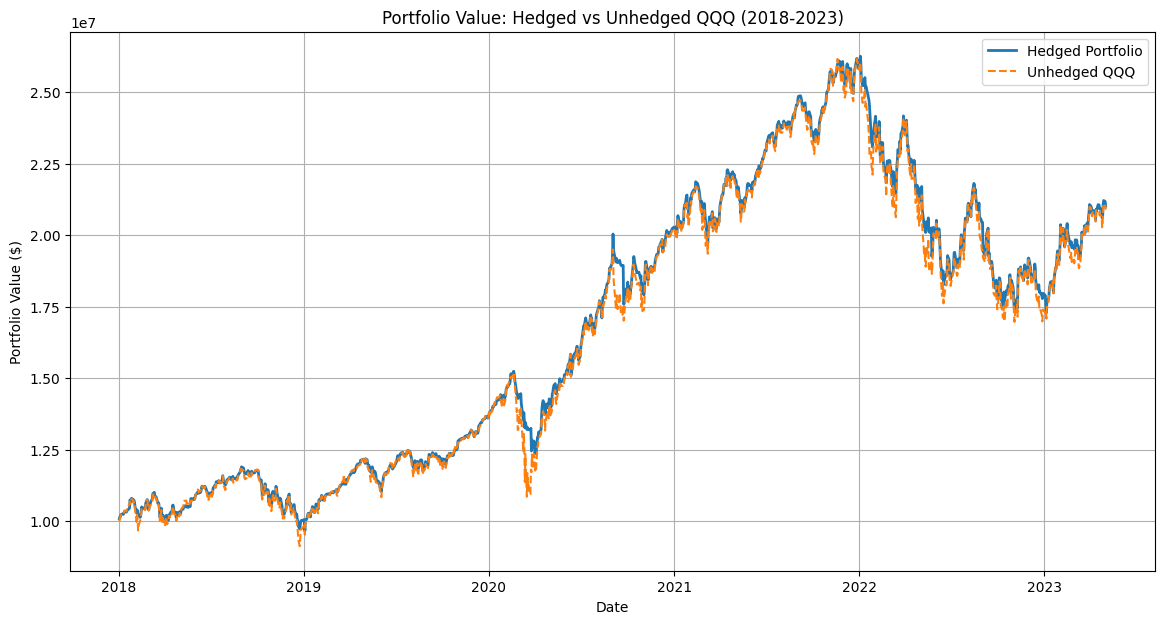

In [75]:
import matplotlib.pyplot as plt

def calculate_metrics(portfolio_values):
    returns = portfolio_values.pct_change().dropna()
    cumulative_return = portfolio_values.iloc[-1] / portfolio_values.iloc[0] - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(portfolio_values)) - 1
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    
    cumulative_max = portfolio_values.cummax()
    drawdown = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    
    return {
        'Cumulative Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate for Hedged and Unhedged
hedged_metrics = calculate_metrics(qqq_daily['Portfolio_Value'])
unhedged_values = initial_investment * qqq_daily['QQQ_Close'] / qqq_daily['QQQ_Close'].iloc[0]
unhedged_metrics = calculate_metrics(unhedged_values)

# Correct Display
print("\n=== Hedged Portfolio Metrics ===")
for k, v in hedged_metrics.items():
    if 'Sharpe' in k:
        print(f"{k}: {v:.2f}")   # No percent for Sharpe Ratio
    else:
        print(f"{k}: {v:.2%}")    # Percent format for returns, vol

print("\n=== Unhedged QQQ Metrics ===")
for k, v in unhedged_metrics.items():
    if 'Sharpe' in k:
        print(f"{k}: {v:.2f}")   # No percent for Sharpe Ratio
    else:
        print(f"{k}: {v:.2%}")    # Percent format for returns, vol



plt.figure(figsize=(14,7))
plt.plot(qqq_daily['Date'], qqq_daily['Portfolio_Value'], label='Hedged Portfolio', linewidth=2)
plt.plot(qqq_daily['Date'], initial_investment * qqq_daily['QQQ_Close'] / qqq_daily['QQQ_Close'].iloc[0], label='Unhedged QQQ', linestyle='--')
plt.title('Portfolio Value: Hedged vs Unhedged QQQ (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

## With delta hedging (not needed and wrong)

In [78]:
# === Setup Parameters ===
rebalance_frequency = 20
strike_offset_call = 1.05
strike_offset_put_buy = 0.97
strike_offset_put_sell = 0.95
risk_free_rate = 0.00

initial_investment = 10_000_000
stock_quantity = initial_investment / qqq_daily['QQQ_Close'].iloc[0]
cash = 0
portfolio_value = []
active_options = []
target_delta = 0

# Track daily net delta if you want to plot later
daily_net_delta = []

# === Run Simulation ===
for i, row in qqq_daily.iterrows():
    S = row['QQQ_Close']
    r = row["risk_free_daily"]

    # === Rebalance Hedge every X days ===
    if i % rebalance_frequency == 0:
        active_options = []  # Close old options
        regime = row['Regime']

        # Covered call strategy
        if regime == 'Low':
            call_strike = S * strike_offset_call
            call_option = find_closest_option(row, options_data, 'C', call_strike)
            if call_option is not None:
                premium = call_option['best_bid'] * 100
                cash += premium
                active_options.append({
                    'type': 'call',
                    'strike': call_option['strike'],
                    'expiration': call_option['expiration_date_option'],
                    'entry_price': call_option['best_bid'],
                    'contracts': stock_quantity / 100,
                    'direction': -1,
                    'implied_vol': call_option['impl_volatility']
                })
                print(f"[Low regime {row['Date'].date()}] Selling CALL @ {call_option['strike']:.2f}, expiry {call_option['expiration_date_option']}, IV={call_option['impl_volatility']:.2f}")
            else:
                print(f"[Low regime {row['Date'].date()}] None")


        elif regime == 'Moderate':
            put_buy_strike = S * strike_offset_put_buy
            put_buy_option = find_closest_option(row, options_data, 'P', put_buy_strike)
            put_sell_strike = S * strike_offset_put_sell
            put_sell_option = find_closest_option(row, options_data, 'P', put_sell_strike)
            call_strike = S * strike_offset_call
            call_option = find_closest_option(row, options_data, 'C', call_strike)

            if put_buy_option is not None:
                premium = put_buy_option['best_offer'] * 100
                cash -= premium
                active_options.append({
                    'type': 'put',
                    'strike': put_buy_option['strike'],
                    'expiration': put_buy_option['expiration_date_option'],
                    'entry_price': put_buy_option['best_offer'],
                    'contracts': stock_quantity / 100,
                    'direction': 1,
                    'implied_vol': put_buy_option['impl_volatility']
                })
                print(f"Mod regime [{row['Date'].date()}] Buying PUT @ {put_buy_option['strike']:.2f}, expiry {put_buy_option['expiration_date_option']}, IV={put_buy_option['impl_volatility']:.2f}")
            else:
                print(f"[Mod regime {row['Date'].date()}] No PUT found")

            if put_sell_option is not None:
                premium = put_sell_option['best_bid'] * 100
                cash += premium
                active_options.append({
                    'type': 'put',
                    'strike': put_sell_option['strike'],
                    'expiration': put_sell_option['expiration_date_option'],
                    'entry_price': put_sell_option['best_bid'],
                    'contracts': stock_quantity / 100,
                    'direction': -1,
                    'implied_vol': put_sell_option['impl_volatility']
                })
                print(f"[Mod regime {row['Date'].date()}] Selling PUT @ {put_buy_option['strike']:.2f}, expiry {put_buy_option['expiration_date_option']}, IV={put_buy_option['impl_volatility']:.2f}")
            else:
                print(f"[Mod regime {row['Date'].date()}] No PUT found")


            if call_option is not None:
                premium = call_option['best_bid'] * 100
                cash += premium
                active_options.append({
                    'type': 'call',
                    'strike': call_option['strike'],
                    'expiration': call_option['expiration_date_option'],
                    'entry_price': call_option['best_bid'],
                    'contracts': stock_quantity / 100,
                    'direction': -1,
                    'implied_vol': call_option['impl_volatility']
                })
                print(f"[Mod regime {row['Date'].date()}] CALL @ {call_option['strike']:.2f}, expiry {call_option['expiration_date_option']}, IV={call_option['impl_volatility']:.2f}")
            else:
                print(f"[Mod regime {row['Date'].date()}] None")

### Collar
        elif regime == 'High':
            put_buy_strike = S * strike_offset_put_buy
            put_buy_option = find_closest_option(row, options_data, 'P', put_buy_strike)
            call_strike = S * strike_offset_call
            call_option = find_closest_option(row, options_data, 'C', call_strike)

            if put_buy_option is not None:
                premium = put_buy_option['best_offer'] * 100
                cash -= premium
                active_options.append({
                    'type': 'put',
                    'strike': put_buy_option['strike'],
                    'expiration': put_buy_option['expiration_date_option'],
                    'entry_price': put_buy_option['best_offer'],
                    'contracts': stock_quantity / 100,
                    'direction': 1,
                    'implied_vol': put_buy_option['impl_volatility']
                })
                print(f"[high regime {row['Date'].date()}] Buying PUT @ {put_buy_option['strike']:.2f}, expiry {put_buy_option['expiration_date_option']}, IV={put_buy_option['impl_volatility']:.2f}")
            else:
                print(f"[high regime {row['Date'].date()}] No PUT found")

            if call_option is not None:
                premium = call_option['best_bid'] * 100
                cash += premium
                active_options.append({
                    'type': 'call',
                    'strike': call_option['strike'],
                    'expiration': call_option['expiration_date_option'],
                    'entry_price': call_option['best_bid'],
                    'contracts': stock_quantity / 100,
                    'direction': -1,
                    'implied_vol': call_option['impl_volatility']
                })
                print(f"[high regime{row['Date'].date()}] Selling CALL @ {call_option['strike']:.2f}, expiry {call_option['expiration_date_option']}, IV={call_option['impl_volatility']:.2f}")
            else:
                print(f"[high regime{row['Date'].date()}] None")

    # === Daily MTM Option Pricing ===
    option_value = 0
    option_net_delta = 0
    for hedge in active_options:
        expiration_date = pd.to_datetime(hedge['expiration'])
        T = (expiration_date - row['Date']).days / 365
        if T > 0:
            price = bs_price(S, hedge['strike'], T, risk_free_rate, hedge['implied_vol'], hedge['type'])
            d1 = (np.log(S / hedge['strike']) + (risk_free_rate + 0.5 * hedge['implied_vol']**2) * T) / (hedge['implied_vol'] * np.sqrt(T))
            delta = norm.cdf(d1) if hedge['type'] == 'call' else (norm.cdf(d1) - 1)
        else:
            price = 0
            delta = 0

        option_value += hedge['contracts'] * hedge['direction'] * price * 100
        option_net_delta += hedge['contracts'] * hedge['direction'] * delta * 100

    # === Delta Hedging (Only when exceeding 10% threshold) ===
    portfolio_delta = stock_quantity + option_net_delta
    delta_to_hedge = target_delta - portfolio_delta
    #print(portfolio_delta)


    # New logic: Only hedge if delta exceeds 10% of stock_quantity
    if regime == "High":
        if abs(delta_to_hedge) > 0.2 * stock_quantity:
            shares_to_trade = np.sign(delta_to_hedge) * min(abs(delta_to_hedge), 500)  # Hedge max 500 shares each time
            cash -= shares_to_trade * S
            stock_quantity += shares_to_trade

    # === Update Portfolio ===
    total_value = stock_quantity * S + cash + option_value
    portfolio_value.append(total_value)

    # Save daily delta
    daily_net_delta.append(portfolio_delta)

# Finalize
qqq_daily['Portfolio_Value'] = portfolio_value
qqq_daily['Net_Delta'] = daily_net_delta

[Low regime 2018-01-02] Selling CALL @ 158.50, expiry 2018-02-02, IV=0.12
[Low regime 2018-01-31] Selling CALL @ 169.50, expiry 2018-03-02, IV=0.17
Mod regime [2018-03-01] Buying PUT @ 152.00, expiry 2018-03-29, IV=0.29
[Mod regime 2018-03-01] Selling PUT @ 152.00, expiry 2018-03-29, IV=0.29
[Mod regime 2018-03-01] CALL @ 164.50, expiry 2018-04-06, IV=0.21
Mod regime [2018-03-29] Buying PUT @ 148.00, expiry 2018-04-27, IV=0.31
[Mod regime 2018-03-29] Selling PUT @ 148.00, expiry 2018-04-27, IV=0.31
[Mod regime 2018-03-29] CALL @ 160.00, expiry 2018-04-27, IV=0.26
Mod regime [2018-04-27] Buying PUT @ 150.00, expiry 2018-06-01, IV=0.24
[Mod regime 2018-04-27] Selling PUT @ 150.00, expiry 2018-06-01, IV=0.24
[Mod regime 2018-04-27] CALL @ 162.50, expiry 2018-05-25, IV=0.19
[Low regime 2018-05-25] Selling CALL @ 170.00, expiry 2018-07-06, IV=0.13
Mod regime [2018-06-25] Buying PUT @ 159.00, expiry 2018-07-20, IV=0.27
[Mod regime 2018-06-25] Selling PUT @ 159.00, expiry 2018-07-20, IV=0.27


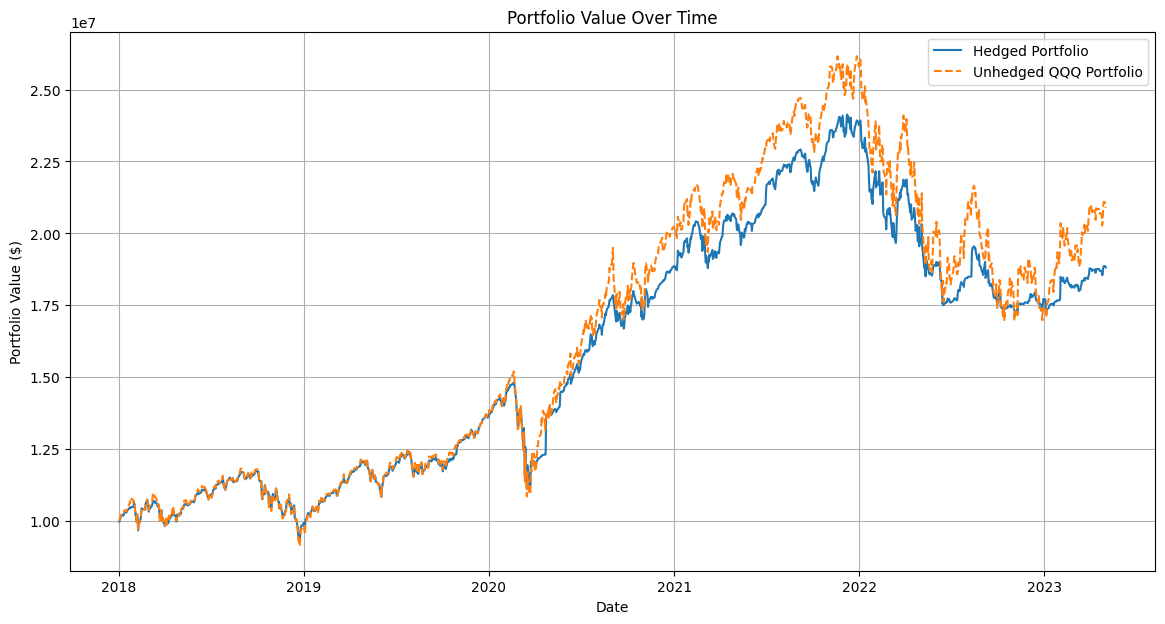

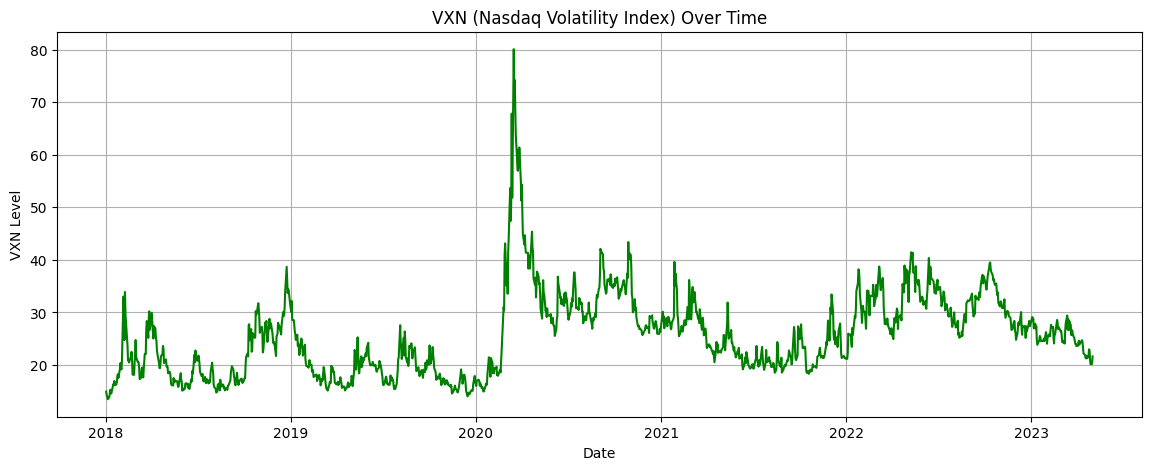

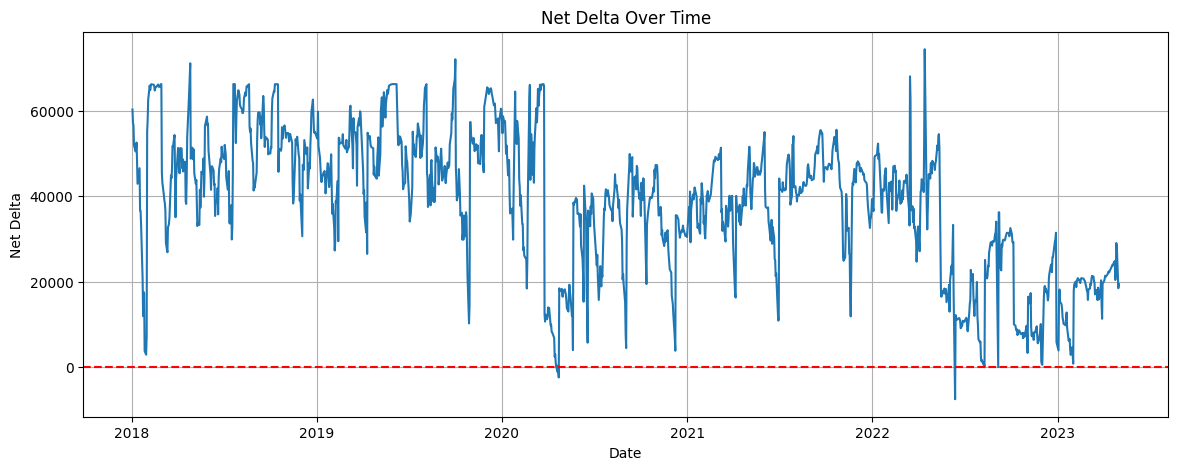

({'Cumulative Return': 0.8842857547967482,
  'Annualized Return': 0.1263332467917675,
  'Annualized Volatility': 0.1907492062328315,
  'Sharpe Ratio': 0.6623002490378027,
  'Max Drawdown': -0.2855139005890042},
 {'Cumulative Return': 1.0889967089584922,
  'Annualized Return': 0.14835913792569166,
  'Annualized Volatility': 0.2589597208163834,
  'Sharpe Ratio': 0.5729043013252489,
  'Max Drawdown': -0.35118742182522594})

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Create unhedged portfolio for comparison
initial_investment = 10_000_000
unhedged_values = initial_investment * qqq_daily['QQQ_Close'] / qqq_daily['QQQ_Close'].iloc[0]

# --- Performance Plot ---
plt.figure(figsize=(14, 7))
plt.plot(qqq_daily['Date'], qqq_daily['Portfolio_Value'], label='Hedged Portfolio')
plt.plot(qqq_daily['Date'], unhedged_values, label='Unhedged QQQ Portfolio', linestyle='--')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(vxn_daily['Date'], vxn_daily['Close'], color='green')
plt.title('VXN (Nasdaq Volatility Index) Over Time')
plt.xlabel('Date')
plt.ylabel('VXN Level')
plt.grid(True)
plt.show()


# --- Net Delta Over Time ---
plt.figure(figsize=(14, 5))
plt.plot(qqq_daily['Date'], qqq_daily['Net_Delta'])
plt.axhline(0, color='red', linestyle='--')
plt.title('Net Delta Over Time')
plt.xlabel('Date')
plt.ylabel('Net Delta')
plt.grid(True)
plt.show()

# --- Metrics Calculation ---
def calculate_metrics(portfolio_values):
    returns = portfolio_values.pct_change().dropna()
    cumulative_return = portfolio_values.iloc[-1] / portfolio_values.iloc[0] - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(portfolio_values)) - 1
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    
    cumulative_max = portfolio_values.cummax()
    drawdown = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    
    return {
        'Cumulative Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

hedged_metrics = calculate_metrics(qqq_daily['Portfolio_Value'])
unhedged_metrics = calculate_metrics(unhedged_values)

hedged_metrics, unhedged_metrics
